In [3]:
from category_classification.data_utils import create_dataframe
from utils.preprocess import count_categories

training_ds = create_dataframe("train", "xx")
test_ds = create_dataframe("test", "xx")
val_ds = create_dataframe("val", "xx")

# Construct the complete dataset from the train/val/test datasets.
# complete_ds = training_ds.append(test_ds).append(val_ds)

In [64]:
from robotoff.taxonomy import Taxonomy
import pandas as pd

categories = count_categories(training_ds)
category_taxonomy = Taxonomy.from_json("data/categories.full.json")

with open("data/agribalyse_categories.txt", "r") as f:
    argibalyse_categories = set(f.read().split(","))
    


In [150]:
categories_by_filter = pd.DataFrame()

categories_by_filter['at least N products'] = range(1, 101)

categories_by_filter['Total'] = [[key for key,value in categories.items() if value >= i and key in category_taxonomy] for i in range(1, 101)]
categories_by_filter['Agribalyse'] = [[key for key,value in categories.items() if value >= i and key in argibalyse_categories] for i in range(1, 101)]

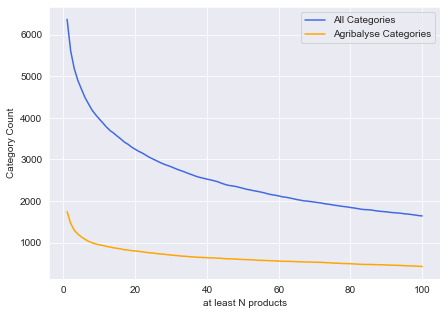

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

plt.figure(figsize=(7, 5))
plt.ylabel("Category Count")
sns.lineplot(y=[len(cat) for cat in categories_by_filter['Total']], x=categories_by_filter['at least N products'], color="royalblue")
sns.lineplot(y=[len(cat) for cat in categories_by_filter['Agribalyse']], x=categories_by_filter['at least N products'], color="orange")
graph.set_xticks(range(0,110, 10))
plt.legend(labels=['All Categories', 'Agribalyse Categories',])

plt.show(graph)

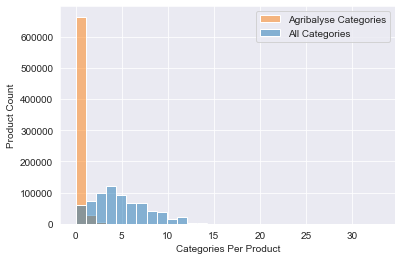

In [199]:
training_ds['total_category_count'] = [len(x) for x in training_ds['categories_tags']]
training_ds['agribalyse_category_count'] = [len([category for category in x if category in argibalyse_categories]) for x in training_ds['categories_tags'] ]

graph = sns.histplot([training_ds['total_category_count'], training_ds['agribalyse_category_count']], bins=30)
graph.set(xlabel='Categories Per Product', ylabel='Product Count')
plt.legend(labels=['Agribalyse Categories','All Categories', ])

In [193]:
all_categories_10 = set(categories_by_filter.iloc[9]['Total'])
agri_categories_10 = set(categories_by_filter.iloc[9]['Agribalyse'])

In [194]:
print(len(all_categories_10))
print(len(agri_categories_10))

print(len(categories_by_filter.iloc[0]['Total']))
print(len(categories_by_filter.iloc[0]['Agribalyse']))

3969
949
6364
1747


In [196]:
training_ds['total_category_count_10'] = [len([cat for cat in x if cat in all_categories_10]) for x in training_ds['categories_tags']]
training_ds['agribalyse_category_count_10'] = [len([category for category in x if category in agri_categories_10]) for x in training_ds['categories_tags'] ]

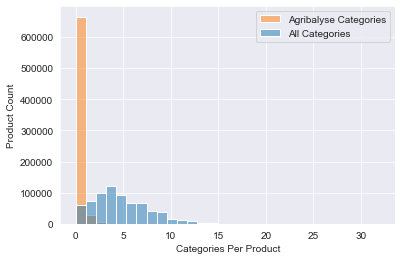

In [200]:
graph = sns.histplot([training_ds['total_category_count_10'], training_ds['agribalyse_category_count_10']], bins=30)
graph.set(xlabel='Categories Per Product', ylabel='Product Count')
plt.legend(labels=['Agribalyse Categories', 'All Categories'])

In [207]:
import argparse
import functools
import operator
import pathlib
from typing import Dict

from bokeh.plotting import save
import pandas as pd
from robotoff.taxonomy import Taxonomy
from robotoff.utils import gzip_jsonl_iter
from tensorflow import keras

import settings
from category_classification.data_utils import generate_data_from_df
from utils.error_analysis import (
    generate_analysis_model,
    get_deepest_categories,
    get_interactive_embedding_plot,
    get_error_category,
)

from utils.io import (
    load_config,
    load_category_vocabulary,
    load_ingredient_vocabulary,
    load_product_name_vocabulary,
)
from utils.metrics import evaluation_report
from utils.preprocess import get_nlp



model_dir = pathlib.Path("weights/0")
model_path ="weights/0/saved_model"

config = load_config(model_dir)

category_to_id = load_category_vocabulary(model_dir)
ingredient_to_id = load_ingredient_vocabulary(model_dir)
category_names = [
    category
    for category, _ in sorted(category_to_id.items(), key=operator.itemgetter(1))
]

nlp = get_nlp(config.lang)

product_name_vocabulary = load_product_name_vocabulary(model_dir)
model = keras.models.load_model(model_path)

generate_data_partial = functools.partial(
    generate_data_from_df,
    ingredient_to_id=ingredient_to_id,
    category_to_id=category_to_id,
    product_name_max_length=config.model_config.product_name_max_length,
    product_name_token_to_int=product_name_vocabulary,
    nlp=nlp,
    product_name_preprocessing_config=config.product_name_preprocessing_config,
    nutriment_input=config.model_config.nutriment_input,
)

category_taxonomy: Taxonomy = Taxonomy.from_json(settings.CATEGORY_TAXONOMY_PATH)

X_val, y_val = generate_data_partial(test_ds)

y_pred_val = model.predict(X_val)

predicted = [
        [{category_names[i]: conf} for i, conf in sorted(enumerate(y)) if conf >= 0.5]
        for y in y_pred_val
    ]


test_ds["predicted categories"] = [[p for p in preds if next(iter(p)) in categories]
    for preds, categories in zip(predicted, test_ds.categories_tags)]


test_ds["wrong prediction"] = [[p for p in preds if next(iter(p)) not in categories]
        for preds, categories in zip(predicted, test_ds.categories_tags)]
    

In [305]:
predictions = []

for index, row in test_ds.iterrows():
    lang = row["lang"]
    for cat in row["predicted categories"]:
        predictions.append((list(cat.values())[0], "Correct", lang))
    for cat in row["wrong prediction"]:
        predictions.append((list(cat.values())[0], "Incorrect"))
        
predictions_df = pd.DataFrame(predictions, columns=["Score", "Prediction Type", "Language"])

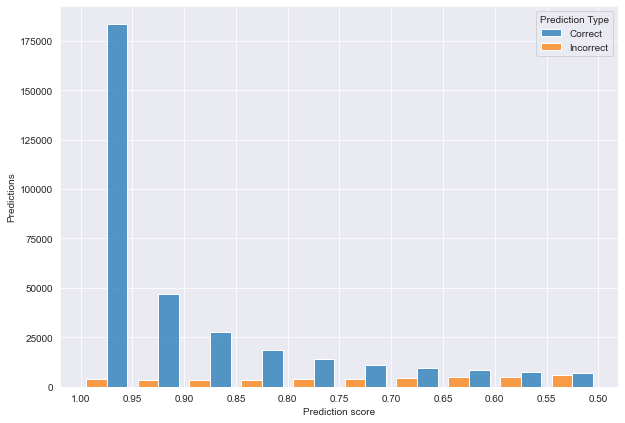

In [228]:
import numpy as np

plt.figure(figsize=(10, 7))
graph = sns.histplot(data=predictions_df, x='Score', hue='Prediction Type' ,multiple="dodge", bins=10, shrink=.8)
graph.set(xlabel='Prediction score', ylabel='Predictions')
graph.set_xticks(np.arange(0.5, 1.05, 0.05))
plt.gca().invert_xaxis()


In [297]:
agribalyse_predictions = []

for index, row in test_ds.iterrows():
    for cat in row["predicted categories"]:
        category = list(cat.values())[0]
        if list(cat.keys())[0] not in argibalyse_categories:
            continue
        agribalyse_predictions.append((list(cat.values())[0], "Correct"))
    for cat in row["wrong prediction"]:
        if list(cat.keys())[0] not in argibalyse_categories:
            continue
        agribalyse_predictions.append((list(cat.values())[0], "Incorrect"))
        
agribalyse_predictions_df = pd.DataFrame(agribalyse_predictions, columns=["Score", "Prediction Type"])

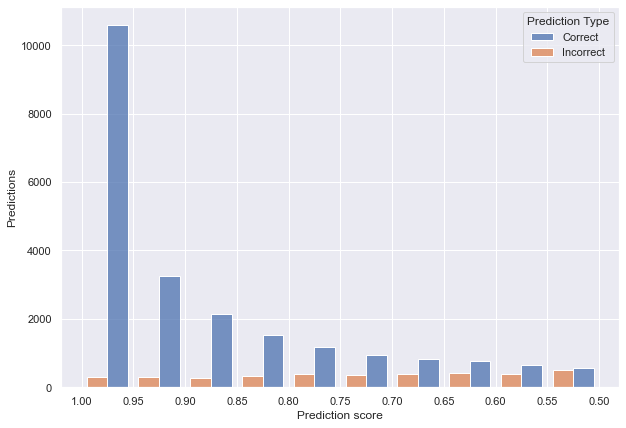

In [303]:
plt.figure(figsize=(10, 7))
graph = sns.histplot(data=agribalyse_predictions_df, x='Score', hue='Prediction Type' ,multiple="dodge", bins=10, shrink=.8, hue_order = ['Correct', 'Incorrect'])
graph.set(xlabel='Prediction score', ylabel='Predictions')
graph.set_xticks(np.arange(0.5, 1.05, 0.05))
plt.gca().invert_xaxis()

In [230]:
unique_langs = test_ds.lang.unique()

test_ds_by_lang = {elem : pd.DataFrame for elem in unique_langs}

for key in test_ds_by_lang.keys():
    test_ds_by_lang[key] = test_ds[:][test_ds.lang == key]

In [256]:
import operator
from typing import Optional, List, Dict

import numpy as np
from robotoff.taxonomy import Taxonomy

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)


def fill_ancestors(
    y: np.ndarray,
    taxonomy: Taxonomy,
    category_to_id: Optional[Dict[str, int]] = None,
    category_names: Optional[List[str]] = None,
):
    if category_to_id is None and category_names is None:
        raise ValueError("one of category_to_id, category_names must be provided")

    if category_names is None:
        category_names = [
            cat for cat, _ in sorted(category_to_id.items(), key=operator.itemgetter(1))
        ]
    elif category_to_id is None:
        category_to_id = {cat: i for i, cat in enumerate(category_names)}

    y_ = y.copy()
    for i in range(y_.shape[1]):
        cat_mask = y_[:, i].nonzero()[0]

        if len(cat_mask):
            category_name = category_names[i]
            parents = taxonomy[category_name].get_parents_hierarchy()
            parent_ids = [category_to_id[parent.id] for parent in parents]
            for parent_id in parent_ids:
                y_[cat_mask, parent_id] = 1

    return y_


def evaluation_report(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    taxonomy: Taxonomy,
    category_names: Optional[List[str]],
):
    y_pred_int = (y_pred > 0.5).astype(y_pred.dtype)
    y_pred_int_filled = fill_ancestors(
        y_pred_int, taxonomy=taxonomy, category_names=category_names
    )

    clf_report = None

    report = {}

    for metric, metric_func in (
        ("precision", precision_score),
        ("recall", recall_score),
        ("f1", f1_score),
    ):
        for average in ("micro", "macro"):
            metric_value = metric_func(y_true, y_pred_int, average=average)
            report["{}-{}".format(average, metric)] = metric_value

    return report, clf_report


In [257]:
from category_classification.data_utils import generate_data_from_df


lang_metrics = pd.DataFrame(columns=["lang", "size", "micro-precision", "micro-recall"])


for key, val in test_ds_by_lang.items():
    X, y = generate_data_from_df(
        val,
        ingredient_to_id,
        category_to_id,
        product_name_vocabulary,
        nlp=nlp,
        product_name_max_length=config.model_config.product_name_max_length,
        product_name_preprocessing_config=config.product_name_preprocessing_config,
        nutriment_input=config.model_config.nutriment_input)
    y_pred = model.predict(X)
    report, clf_report = evaluation_report(
        y, y_pred, taxonomy=category_taxonomy, category_names=category_names
    )
    lang_metrics = lang_metrics.append({
        "lang": key,
        "size":  len(val),
        "micro-precision": report["micro-precision"],
        "micro-recall": report["micro-recall"],
      }, ignore_index=True)
    print("Done with lang: {}".format(key))

Done with lang: de
Done with lang: en
Done with lang: es
Done with lang: fr
Done with lang: it
Done with lang: cs
Done with lang: pt
Done with lang: ru
Done with lang: th
Done with lang: fi
Done with lang: pl
Done with lang: el
Done with lang: nl
Done with lang: ro
Done with lang: hu
Done with lang: sv
Done with lang: sr
Done with lang: sq
Done with lang: ar
Done with lang: nb
Done with lang: bs
Done with lang: ca
Done with lang: hr
Done with lang: da
Done with lang: mk
Done with lang: lb
Done with lang: bg
Done with lang: tr
Done with lang: lt
Done with lang: sk
Done with lang: sl
Done with lang: is
Done with lang: la
Done with lang: ka
Done with lang: fa
Done with lang: uk
Done with lang: ja
Done with lang: he
Done with lang: zh
Done with lang: lv
Done with lang: az
Done with lang: id
Done with lang: et
Done with lang: world
Done with lang: no
Done with lang: xx
Done with lang: ms
Done with lang: mr


/Users/ykulizhskaya/off/robotoff/off-category-classification/venv/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,
/Users/ykulizhskaya/off/robotoff/off-category-classification/venv/lib/python3.8/site-packages/sklearn/metrics/classification.py:1436: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  precision = _prf_divide(tp_sum, pred_sum,


Done with lang: jv
Done with lang: pt-BR
Done with lang: ko


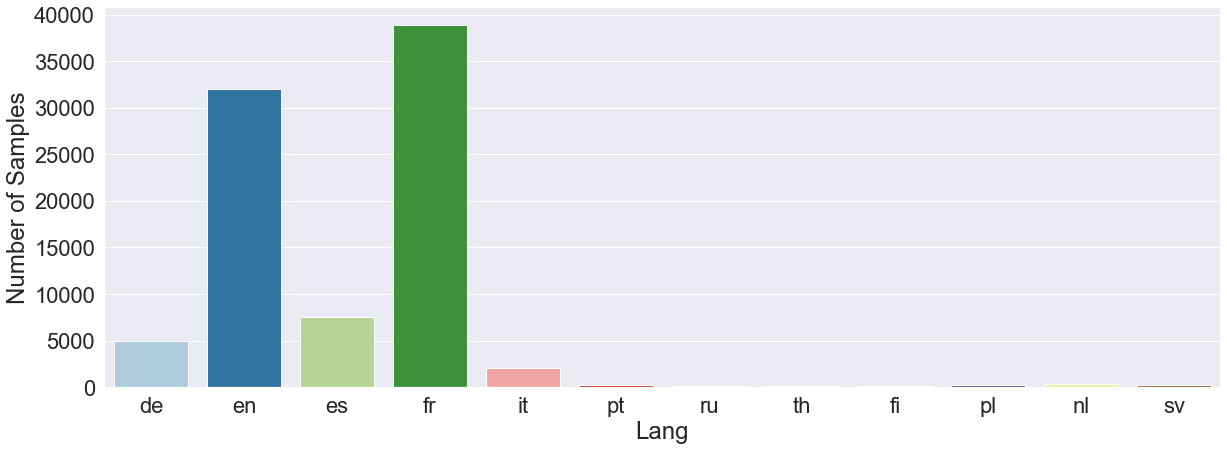

In [288]:
plt.figure(figsize=(20, 7))
graph = sns.barplot(data=lang_metrics[lang_metrics['size'] > 100], x='lang', y='size', palette="Paired")
graph.set(xlabel='Lang', ylabel='Number of Samples')
sns.set(font_scale = 1)

<AxesSubplot:xlabel='micro-precision', ylabel='micro-recall'>

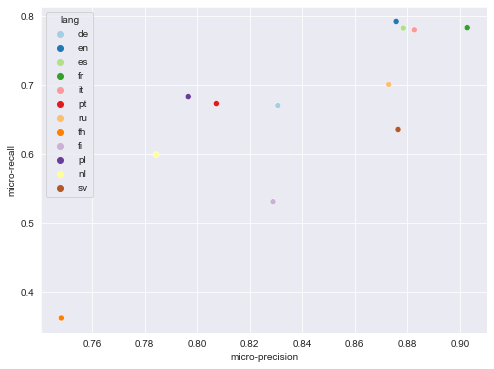

In [283]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=lang_metrics[lang_metrics['size'] > 100], x="micro-precision", y="micro-recall", hue="lang",  palette="Paired")